In [1]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993224 sha256=77207f14714218937b2ebb3010eedd6d5b2e87b7aaffcd25a9899dd3dfa72873
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect


In [2]:
import pandas as pd
import seaborn as sns
import nltk
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from scipy.stats import uniform, randint
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, RepeatedStratifiedKFold
import xgboost as xgb
from sklearn.metrics import make_scorer, f1_score

In [16]:
from google.colab import drive
drive.mount('/content/drive')
ds_reseñas = pd.read_csv("./drive/MyDrive/datasets/train.csv")
ds = ds_reseñas.copy()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
ds

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
...,...,...,...
49995,49995,Pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,"Mala parcela, mal diálogo, mala actuación, dir...",negativo
49997,49997,Soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,Voy a tener que estar en desacuerdo con el com...,negativo


# **Modelo sin preprocesamiento de textos**

In [22]:
vectorizer = CountVectorizer(min_df=0.1, max_df=0.7,token_pattern=r'\b(?:[^\d\W_])+\b')
X = vectorizer.fit_transform(ds['review_es'])
palabras = vectorizer.get_feature_names_out()
print(palabras)
print(len(palabras))
print(X.toarray())

['actores' 'actuación' 'ahora' 'al' 'algo' 'alguien' 'algunas' 'algunos'
 'antes' 'aquí' 'así' 'aunque' 'años' 'aún' 'bastante' 'bien' 'buen'
 'buena' 'bueno' 'cada' 'casi' 'cine' 'como' 'con' 'cosas' 'creo'
 'cualquier' 'cuando' 'cómo' 'debe' 'decir' 'del' 'demasiado' 'desde'
 'después' 'director' 'donde' 'dos' 'durante' 'e' 'ella' 'ellos' 'embargo'
 'entonces' 'entre' 'era' 'esa' 'escena' 'escenas' 'ese' 'eso' 'estaba'
 'este' 'esto' 'estoy' 'está' 'están' 'final' 'forma' 'fue' 'fuera' 'gran'
 'ha' 'haber' 'había' 'hace' 'hacer' 'han' 'hasta' 'hay' 'he' 'hecho'
 'historia' 'hizo' 'hombre' 'incluso' 'le' 'luego' 'lugar' 'mal' 'manera'
 'mayoría' 'me' 'mejor' 'mejores' 'menos' 'mi' 'mientras' 'minutos'
 'mismo' 'momento' 'muchas' 'mucho' 'muchos' 'muy' 'más' 'nada' 'ni'
 'nunca' 'o' 'otra' 'otro' 'otros' 'parece' 'parte' 'películas' 'pero'
 'personaje' 'personajes' 'personas' 'poco' 'podría' 'porque' 'primera'
 'puede' 'puedo' 'qué' 'real' 'realidad' 'realmente' 'sea' 'ser' 'si'
 'sido

In [23]:
for i, palabra in enumerate(palabras):
    ds[palabra] = X.toarray()[:, i]


<ipython-input-23-2ed3989da0e1>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[palabra] = X.toarray()[:, i]
<ipython-input-23-2ed3989da0e1>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[palabra] = X.toarray()[:, i]
<ipython-input-23-2ed3989da0e1>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

In [25]:
from sklearn.preprocessing import LabelEncoder
ds.drop(columns='ID',inplace=True)
ds.drop(columns='review_es',inplace=True)

ds_x=ds.drop(['sentimiento'], axis='columns', inplace=False)
ds_y = ds['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=4, #semilla
                                                    stratify=ds["sentimiento"].values)


In [26]:
print(y_train)
le = LabelEncoder()
print(le.fit_transform(y_train))
y_train = le.fit_transform(y_train)

12477    negativo
1406     positivo
25569    positivo
36403    negativo
29892    negativo
           ...   
23681    positivo
15643    positivo
48204    positivo
35761    positivo
38821    positivo
Name: sentimiento, Length: 35000, dtype: object
[0 1 1 ... 1 1 1]


In [10]:
from xgboost.sklearn import XGBClassifier
#Parámetros a optimizar
params_grid = {'n_estimators':randint(100, 150), 'max_depth':randint(2,6), 'learning_rate':uniform(0.1,0.3), "colsample_bytree": uniform(0.7, 0.3), "alpha": uniform(0.01,0.2), "subsample": uniform(0.6, 0.4)}

#Folds
kfoldcv = StratifiedKFold(n_splits=5)
scorer_fn = make_scorer(f1_score)

#Ramdom Search CV
randomcv = RandomizedSearchCV(XGBClassifier(), params_grid, scoring=scorer_fn, random_state=42, n_iter=10, cv=kfoldcv, verbose=1, n_jobs=1, return_train_score=True)
randomcv.fit(x_train,y_train)

print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
gb = randomcv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


ValueError: ignored

'alpha': 0.17663898234723288, 'colsample_bytree': 0.7520093960523315, 'learning_rate': 0.21731818227197225, 'max_depth': 3, 'n_estimators': 139, 'subsample': 0.902144564127061

In [27]:
best_params = {'alpha': 0.17663898234723288, 'colsample_bytree': 0.7520093960523315, 'learning_rate': 0.21731818227197225, 'max_depth': 3, 'n_estimators': 139, 'subsample': 0.902144564127061}
xgb_model=xgb.XGBClassifier().set_params(**best_params)

#Entreno el arbol en todo el set
xgb_model.fit(x_train,y_train)

XGBClassifier(alpha=0.17663898234723288, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7520093960523315, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21731818227197225,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=139, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

F1 Score: 0.7311505348291154
Accuracy Score: 0.7252
Recall Score: 0.7473333333333333
Precision Score: 0.7156537282941777


Text(50.722222222222214, 0.5, 'True')

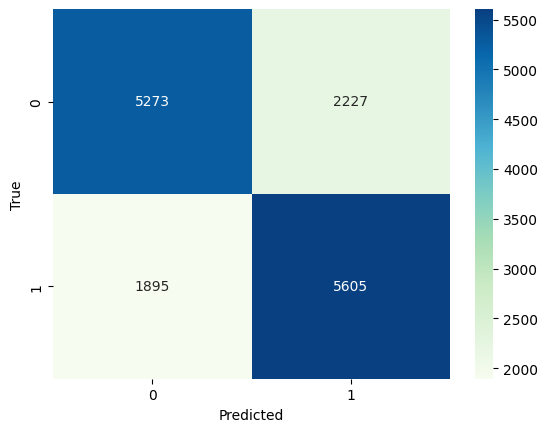

In [28]:
y_pred = xgb_model.predict(x_test)
y_test = le.fit_transform(y_test)
x_pred = le.inverse_transform(y_pred)
print(f"F1 Score: {f1_score(y_test,y_pred, pos_label= 1)}")
print(f"Accuracy Score: {accuracy_score(y_test,y_pred)}")
print(f"Recall Score: {recall_score(y_test,y_pred, pos_label=1)}")
print(f"Precision Score: {precision_score(y_test,y_pred, pos_label=1)}")

tabla=confusion_matrix(y_test, y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

# **Modelo con preprocesamiento de textos**

In [ ]:
import string
import re
ds = ds_reseñas.copy()
ds["review_es"] = ds["review_es"].apply(str.lower)
# remuevo puntuacion
ds["review_es"] = ds["review_es"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
# remuevo espacios de mas
ds["review_es"] = ds["review_es"].apply(lambda x: re.sub(' +', ' ', x))
ds

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado que de...,positivo
1,1,una pequeña pequeña producciónla técnica de fi...,positivo
2,2,pensé que esta era una manera maravillosa de p...,positivo
3,3,básicamente hay una familia donde un niño pequ...,negativo
4,4,el amor en el tiempo de petter mattei es una p...,positivo
...,...,...,...
49995,49995,pensé que esta película hizo un buen trabajo a...,positivo
49996,49996,mala parcela mal diálogo mala actuación direcc...,negativo
49997,49997,soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,voy a tener que estar en desacuerdo con el com...,negativo


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
nltk.download('punkt')

nltk.download('stopwords')
sw_nltk = stopwords.words('spanish')
dist = FreqDist()
def numeracion_de_stopwords(texto):
  for word in word_tokenize(texto):
    if word in sw_nltk:
      dist[word.lower()] += 1
ds["review_es"].apply(numeracion_de_stopwords)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0        None
1        None
2        None
3        None
4        None
         ... 
49995    None
49996    None
49997    None
49998    None
49999    None
Name: review_es, Length: 50000, dtype: object

In [ ]:
print(dist.most_common(10))

[('de', 659582), ('la', 394200), ('que', 375879), ('y', 295168), ('en', 272294), ('el', 230262), ('a', 215484), ('un', 184480), ('es', 176997), ('una', 168611)]


In [ ]:
# remuevo las stopwords que considero no aportan informacion importante
stopw = []
for palabra in dist.most_common(10):
  stopw.append(palabra[0])
stopw.remove("y")
stopw.remove("en")
stopw.remove("de")
stopw

['la', 'que', 'el', 'a', 'un', 'es', 'una']

In [ ]:
def remover_stopwords(texto):
  palabras = [palabra for palabra in texto.split() if palabra.lower() not in stopw]
  return " ".join(palabras)
ds["review_es"] = ds["review_es"].apply(remover_stopwords)
ds

,ID,review_es,sentimiento
0,0,uno de los otros críticos ha mencionado despué...,positivo
1,1,pequeña pequeña producciónla técnica de filmac...,positivo
2,2,pensé esta era manera maravillosa de pasar tie...,positivo
3,3,básicamente hay familia donde niño pequeño jak...,negativo
4,4,amor en tiempo de petter mattei película visua...,positivo
...,...,...,...
49995,49995,pensé esta película hizo buen trabajo derechan...,positivo
49996,49996,mala parcela mal diálogo mala actuación direcc...,negativo
49997,49997,soy católica enseñada en escuelas primarias pa...,negativo
49998,49998,voy tener estar en desacuerdo con comentario a...,negativo


In [ ]:
from nltk.stem import SnowballStemmer

nltk.download('punkt')

# Inicializar stemmer en español
stemmer = SnowballStemmer('spanish')
# Función para aplicar el stemming a una oración
def stem_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)
# Aplicar el stemming a la columna df.review_es y guardar en una nueva columna
ds['stemmed_review'] = ds['review_es'].apply(stem_sentence)

vectorizer = CountVectorizer(min_df=0.1, max_df=0.7,token_pattern=r'\b(?:[^\d\W_])+\b')
X = vectorizer.fit_transform(ds['stemmed_review'])
palabras = vectorizer.get_feature_names_out()
print(palabras)
print(len(palabras))
print(X.toarray())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


['absolut' 'actor' 'actuacion' 'ahor' 'al' 'algo' 'algui' 'algun' 'amig'
 'antes' 'aqu' 'asi' 'aun' 'aunqu' 'años' 'baj' 'bastant' 'bien' 'buen'
 'cad' 'cas' 'casi' 'chic' 'cin' 'com' 'comedi' 'complet' 'con' 'cos'
 'cre' 'cualqui' 'cuand' 'cuent' 'deb' 'dec' 'dej' 'del' 'demasi' 'desd'
 'despues' 'dic' 'diferent' 'director' 'disfrut' 'divert' 'dond' 'dos'
 'durant' 'e' 'efect' 'el' 'ella' 'ellos' 'embarg' 'encant' 'encontr'
 'encuentr' 'entonc' 'entre' 'era' 'esa' 'escen' 'ese' 'eso' 'especial'
 'esper' 'estab' 'estad' 'estan' 'estar' 'estas' 'este' 'esto' 'estoy'
 'excelent' 'final' 'form' 'fue' 'fuer' 'general' 'gran' 'grand' 'gust'
 'ha' 'hab' 'habl' 'hac' 'han' 'hast' 'hay' 'he' 'hech' 'histori' 'hiz'
 'hombr' 'import' 'inclus' 'increibl' 'intent' 'interes' 'jueg' 'jug'
 'las' 'le' 'llam' 'llev' 'lueg' 'lug' 'mal' 'maner' 'mas' 'mayor' 'me'
 'mejor' 'men' 'mi' 'mientr' 'minut' 'mir' 'mism' 'moment' 'much' 'muert'
 'muy' 'nad' 'ni' 'ningun' 'niñ' 'nuev' 'nunc' 'o' 'otra' 'otro' 'ot

In [ ]:
for i, palabra in enumerate(palabras):
    ds[palabra] = X.toarray()[:, i]

ds.head(10)

<ipython-input-93-da3627cc8361>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[palabra] = X.toarray()[:, i]
<ipython-input-93-da3627cc8361>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  ds[palabra] = X.toarray()[:, i]
<ipython-input-93-da3627cc8361>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy

,ID,review_es,sentimiento,stemmed_review,absolut,actor,actuacion,ahor,al,algo,...,ultim,unic,uno,vec,ver,verdader,vez,vid,vist,ya
0,0,uno de los otros críticos ha mencionado despué...,positivo,uno de los otros critic ha mencion despues de ...,0,0,0,0,2,0,...,0,0,1,0,1,0,0,0,1,2
1,1,pequeña pequeña producciónla técnica de filmac...,positivo,pequeñ pequeñ produccionl tecnic de filmacion ...,0,1,0,0,0,0,...,0,0,1,2,1,0,0,0,0,0
2,2,pensé esta era manera maravillosa de pasar tie...,positivo,pens esta era maner maravill de pas tiemp en f...,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,3,básicamente hay familia donde niño pequeño jak...,negativo,basic hay famili dond niñ pequeñ jak piens hay...,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,4,amor en tiempo de petter mattei película visua...,positivo,amor en tiemp de pett mattei pelicul visual im...,0,0,1,0,0,0,...,0,1,2,0,2,0,0,1,0,1
5,5,probablemente mi película favorita de todos lo...,positivo,probabl mi pelicul favorit de tod los tiemp hi...,0,0,0,0,0,0,...,1,0,1,1,0,1,0,0,1,0
6,6,seguro me gustaría ver resurrección de serie d...,positivo,segur me gust ver resurreccion de seri de seah...,0,0,0,0,0,0,...,0,0,0,0,2,0,0,0,2,0
7,7,este espectáculo fue idea increíble fresca e i...,negativo,este espectacul fue ide increibl fresc e innov...,0,0,1,1,0,0,...,0,0,0,0,0,1,0,0,0,1
8,8,alentados por los comentarios positivos sobre ...,negativo,alent por los comentari posit sobr esta pelicu...,0,0,1,0,1,0,...,0,1,1,0,2,1,1,0,1,0
9,9,si te gusta risa original desgarradora te gust...,positivo,si te gust ris original desgarr te gust esta p...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from langdetect import detect

indices = []

for i, fila in ds.iterrows():
    #review = fila['review_es']
    review = fila['stemmed_review']
    if detect(review) != 'es':
        indices.append(i)

ds.iloc[indices]

,ID,review_es,sentimiento,stemmed_review,absolut,actor,actuacion,ahor,al,algo,...,ultim,unic,uno,vec,ver,verdader,vez,vid,vist,ya
9,9,si te gusta risa original desgarradora te gust...,positivo,si te gust ris original desgarr te gust esta p...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
66,66,belleza tetona stacie randall interpreta pvc r...,negativo,bellez teton staci randall interpret pvc reves...,0,0,0,1,1,0,...,0,2,0,0,0,0,1,0,0,2
118,118,ahora he visto algunas películas de pedro almo...,negativo,ahor he vist algun pelicul de pedr almodov per...,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0
156,156,from the films first shot keira knightley as e...,negativo,from the films first shot keir knightley as el...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
209,209,esta película está bien fundida menudo tonta y...,positivo,esta pelicul esta bien fund menud tont y siemp...,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49829,49829,comprometido se trata de graham como optimista...,positivo,compromet se trat de graham com optim irrepres...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49833,49833,the shop around the corner is one of the sweet...,positivo,the shop around the corn is one of the sweetes...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49853,49853,músico y compositor europeo se propone captura...,positivo,music y compositor europe se propon captur div...,0,0,0,0,3,0,...,0,0,0,0,0,0,0,0,0,0
49861,49861,ok ok it might be hard to put the entirety of ...,negativo,ok ok it might be hard to put the entirety of ...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
ds.drop(indices,inplace= True)
ds

,ID,review_es,sentimiento,stemmed_review,absolut,actor,actuacion,ahor,al,algo,...,ultim,unic,uno,vec,ver,verdader,vez,vid,vist,ya
0,0,uno de los otros críticos ha mencionado despué...,positivo,uno de los otros critic ha mencion despues de ...,0,0,0,0,2,0,...,0,0,1,0,1,0,0,0,1,2
1,1,pequeña pequeña producciónla técnica de filmac...,positivo,pequeñ pequeñ produccionl tecnic de filmacion ...,0,1,0,0,0,0,...,0,0,1,2,1,0,0,0,0,0
2,2,pensé esta era manera maravillosa de pasar tie...,positivo,pens esta era maner maravill de pas tiemp en f...,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0
3,3,básicamente hay familia donde niño pequeño jak...,negativo,basic hay famili dond niñ pequeñ jak piens hay...,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
4,4,amor en tiempo de petter mattei película visua...,positivo,amor en tiemp de pett mattei pelicul visual im...,0,0,1,0,0,0,...,0,1,2,0,2,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,49995,pensé esta película hizo buen trabajo derechan...,positivo,pens esta pelicul hiz buen trabaj derechan fue...,0,0,0,1,1,1,...,1,0,0,0,0,0,0,2,0,0
49996,49996,mala parcela mal diálogo mala actuación direcc...,negativo,mal parcel mal dialog mal actuacion direccion ...,0,0,1,0,1,1,...,0,1,0,1,1,0,0,0,0,0
49997,49997,soy católica enseñada en escuelas primarias pa...,negativo,soy catol enseñ en escuel primari parroquial p...,0,0,1,0,0,0,...,0,0,0,0,0,1,0,3,0,0
49998,49998,voy tener estar en desacuerdo con comentario a...,negativo,voy ten estar en desacuerd con comentari anter...,0,0,1,0,0,1,...,1,0,3,0,0,1,0,0,0,2


In [ ]:
from sklearn.preprocessing import LabelEncoder

ds.drop(columns='ID',inplace=True)
ds.drop(columns='review_es',inplace=True)
ds.drop(columns='stemmed_review',inplace=True)


ds_x=ds.drop(['sentimiento'], axis='columns', inplace=False)
ds_y = ds['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=4, #semilla
                                                    stratify=ds["sentimiento"].values)
le = LabelEncoder()
y_train = le.fit_transform(y_train)


In [ ]:
from xgboost.sklearn import XGBClassifier
#Parámetros a optimizar
params_grid = {'n_estimators':randint(100, 150), 'max_depth':randint(2,6), 'learning_rate':uniform(0.1,0.3), "colsample_bytree": uniform(0.7, 0.3), "alpha": uniform(0.01,0.2), "subsample": uniform(0.6, 0.4)}


#Folds
kfoldcv = StratifiedKFold(n_splits=5)
scorer_fn = make_scorer(f1_score)

#Ramdom Search CV
randomcv = RandomizedSearchCV(XGBClassifier(), params_grid, scoring=scorer_fn, random_state=42, n_iter=10, cv=kfoldcv, verbose=1, n_jobs=1, return_train_score=True)
randomcv.fit(x_train,y_train)

print (randomcv.best_score_, randomcv.best_params_)

#Mejor Modelo
gb = randomcv.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7786160419432984 {'alpha': 0.17663898234723288, 'colsample_bytree': 0.7520093960523315, 'learning_rate': 0.21731818227197225, 'max_depth': 3, 'n_estimators': 139, 'subsample': 0.902144564127061}


In [ ]:
best_params = {'alpha': 0.17663898234723288, 'colsample_bytree': 0.7520093960523315, 'learning_rate': 0.21731818227197225, 'max_depth': 3, 'n_estimators': 139, 'subsample': 0.902144564127061}
xgb_model=xgb.XGBClassifier().set_params(**best_params)

#Entreno el arbol en todo el set
xgb_model.fit(x_train,y_train)

XGBClassifier(alpha=0.17663898234723288, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7520093960523315, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.21731818227197225,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=139, n_jobs=None, num_parallel_tree=None,
              predictor=None, ...)

F1 Score: 0.7818642558728853
Accuracy Score: 0.7755936024800958
Recall Score: 0.8045102184637068
Precision Score: 0.7604583000266454


Text(50.722222222222214, 0.5, 'True')

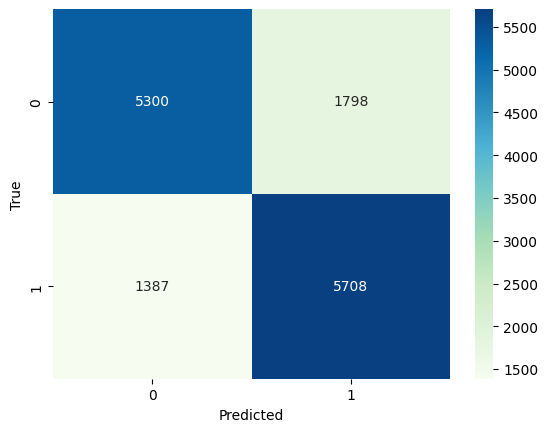

In [ ]:
y_pred = xgb_model.predict(x_test)
y_test = le.fit_transform(y_test)
x_pred = le.inverse_transform(y_pred)
print(f"F1 Score: {f1_score(y_test,y_pred, pos_label= 1)}")
print(f"Accuracy Score: {accuracy_score(y_test,y_pred)}")
print(f"Recall Score: {recall_score(y_test,y_pred, pos_label=1)}")
print(f"Precision Score: {precision_score(y_test,y_pred, pos_label=1)}")

tabla=confusion_matrix(y_test, y_pred)
sns.heatmap(tabla,cmap='GnBu',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

In [ ]:
y_train

array([0, 1, 1, ..., 0, 0, 0])

In [ ]:
x_train

,stemmed_review,absolut,actor,actuacion,ahor,al,algo,algui,algun,amig,...,ultim,unic,uno,vec,ver,verdader,vez,vid,vist,ya
22385,la pelicul es simplement horribl 210aunqu los ...,0,2,0,0,0,0,0,1,0,...,0,0,0,1,1,0,1,0,0,0
24705,cualqui pelicul que muestr a los cerd federal ...,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
33451,recib una pat de los nuev fanat de los que lo ...,0,0,0,2,2,0,0,3,0,...,1,0,0,0,1,0,0,0,0,0
13832,tu primer pist de que esta es una pelicul curs...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41354,sloppily dirig comedi con ingeni que supuest f...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49477,lea mis labi sur mes lèvres que probabl tien u...,0,0,0,0,0,0,0,1,0,...,1,0,1,0,0,1,1,0,1,1
28489,esta pelicul es brillant tien lind pequeñ delf...,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
36821,durant much años vi esta pelicul com una verda...,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,1,0,1,0,0
25629,sol vi esta pelicul una vez y eso fue suficien...,0,0,0,0,0,0,1,1,0,...,0,0,0,0,1,0,1,0,0,1


# **Predict de Kaggle**

In [ ]:
df_criticas_test = pd.read_csv('./drive/MyDrive/datasets/test.csv')
df_test = df_criticas_test.copy()
df_test.head(10)

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
5,60005,La llegada de Rafa a Euskadi es como ponerse a...
6,60006,El nivel del cine y lo peor la capacidad intel...
7,60007,Es triste ver una película como ésta y escucha...
8,60008,Puedo entender que Torrente I y II y Lo imposi...
9,60009,"-Ahivalohostia, Txomin, qué montón de gente ri..."


In [ ]:
df_test['num_palabras'] = df_test['review_es'].str.split().apply(len)

vectorizer = CountVectorizer(vocabulary=palabras)
matriz_caracteristicas_test = vectorizer.fit_transform(df_test['review_es'])

for i, palabra in enumerate(palabras):
    df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]


_df_test = df_test.drop(columns='ID',inplace=False)
_df_test.drop(columns='review_es',inplace=True)
_df_test.drop(columns='num_palabras',inplace=True)

_df_test.head(10)

<ipython-input-100-82460e44654d>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]
<ipython-input-100-82460e44654d>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]
<ipython-input-100-82460e44654d>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) 

,absolut,actor,actuacion,ahor,al,algo,algui,algun,amig,antes,...,ultim,unic,uno,vec,ver,verdader,vez,vid,vist,ya
0,0,0,0,0,5,0,0,0,0,1,...,0,0,1,0,2,0,0,0,0,2
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,2,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,5,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,2,0,1,0,0,0
5,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,2,0,0,0,0,0,...,0,0,2,0,1,0,0,0,0,0
8,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
9,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,2,0,0,0,0,2


In [ ]:
pred_kaggle_rf = xgb_model.predict(_df_test)
df_kaggle_rf = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': pred_kaggle_rf})
df_kaggle_rf.head(10)


,ID,sentimiento
0,60000,0
1,60001,1
2,60002,1
3,60003,0
4,60004,1
5,60005,1
6,60006,0
7,60007,0
8,60008,0
9,60009,1


In [ ]:
def desencodear(res):
  if res == 1:
    return "positivo"
  else:
    return "negativo"
df_kaggle_rf["sentimiento"] = df_kaggle_rf["sentimiento"].apply(desencodear)
df_kaggle_rf

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,positivo
3,60003,negativo
4,60004,positivo
...,...,...
8594,68594,positivo
8595,68595,positivo
8596,68596,negativo
8597,68597,negativo


In [ ]:
df_kaggle_rf.to_csv('./drive/MyDrive/predicciones/pred_xgb4.csv', index=False)

In [ ]:
import joblib
filename = './drive/MyDrive/predicciones/xgb_model.sav'
joblib.dump(xgb_model, filename)

['./drive/MyDrive/predicciones/xgb_model.sav']